XGBoost : 커플 성사 여부 예측

목표: 스피드 데이팅 데이터셋을 이용해 커플 성사 여부를 예측

via 최효원's Jupyter Notebook

스피드 데이팅은 남녀 수십 쌍이 짧은 시간을 보낸 뒤, 서로에 대한 호감도를
표현하여 짝을 매칭하는 이벤트입니다. 독립 변수로는 상대방과 내 정보,
개인 취향, 상대방에 대한 평가 등이 있고 target 변수는 매칭 성사 여부 입니다.

순차적으로 tree 를 만들어 이전 트리로부터 더 나은 트리를 만들어내는 특징을 가진,
트리 모델을 기반으로 한 최신 알고리즘 중 하나인 XGBoost 를 해당 작업에 적용했습니다.

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('https://media.githubusercontent.com/media/musthave-ML10/data_source/main/dating.csv')
#데이터 출처 : https://media.githubusercontent.com/media/musthave-ML10
df.head()

,has_null,gender,age,age_o,race,race_o,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,funny_partner,ambition_partner,shared_interests_partner,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,like,guess_prob_liked,met,match
0,0,female,21.0,27.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,35.0,20.0,...,7.0,6.0,5.0,0.14,3.0,2.0,7.0,6.0,0.0,0
1,0,female,21.0,22.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,60.0,0.0,...,8.0,5.0,6.0,0.54,3.0,2.0,7.0,5.0,1.0,0
2,1,female,21.0,22.0,Asian/PacificIslander/Asian-American,Asian/PacificIslander/Asian-American,2.0,4.0,19.0,18.0,...,8.0,5.0,7.0,0.16,3.0,2.0,7.0,NaN,1.0,1
3,0,female,21.0,23.0,Asian/PacificIslander/Asian-American,European/Caucasian-American,2.0,4.0,30.0,5.0,...,7.0,6.0,8.0,0.61,3.0,2.0,7.0,6.0,0.0,1
4,0,female,21.0,24.0,Asian/PacificIslander/Asian-American,Latino/HispanicAmerican,2.0,4.0,30.0,10.0,...,7.0,6.0,6.0,0.21,3.0,2.0,6.0,6.0,0.0,1


In [2]:
df.info()
#total : 8378 rows / 39 cols

#has_null : null 값이 있는지 여부
#age/age_o : 본인 나이/ 상대방 나이
#race/race_o : 본인 인종/ 상대방 인종
#importance_same_race/ religion : 인종이나 종교를 중요시 여기는지,
#pref_o_xxx : 상대방이 xxx 항목을 얼마나 중요시 여기는지,
#xxx_o : 상대방이 본인에 대한 xxx 항목을 평가한 항목
#xxx_important : xxx 항목에 대해 본인이 얼마나 중요하게 생각하는지,
#xxx_partner : 본인이 상대방에 대한 xxx 항목을 평가
#interests_correlate : 관심사(취미) 연관도
#expected_happy_with_sd_people : 스피드 데이팅을 통해 만난 사람과 함께 할 때, 얼마나 좋을지에 대한 기대치
#expected_num_interested_in_me : 얼마나 많은 사람이 나에게 관심을 보일지에 대한 기대치
#guess_prob_liked : 파트너가 나를 마음에 들어했을지에 대한 예상
#met : 파트너를 스피드 데이팅 이벤트 이전에 만난 적이 있는지 여부
#match : 종속 변수(target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   has_null                       8378 non-null   int64  
 1   gender                         8378 non-null   object 
 2   age                            8283 non-null   float64
 3   age_o                          8274 non-null   float64
 4   race                           8315 non-null   object 
 5   race_o                         8305 non-null   object 
 6   importance_same_race           8299 non-null   float64
 7   importance_same_religion       8299 non-null   float64
 8   pref_o_attractive              8289 non-null   float64
 9   pref_o_sincere                 8289 non-null   float64
 10  pref_o_intelligence            8289 non-null   float64
 11  pref_o_funny                   8280 non-null   float64
 12  pref_o_ambitious               8271 non-null   f

In [3]:
round(df.describe().T, 2)
#데이터 통계 정보 출력

,count,mean,std,min,25%,50%,75%,max
has_null,8378.0,0.87,0.33,0.00,1.00,1.00,1.00,1.00
age,8283.0,26.36,3.57,18.00,24.00,26.00,28.00,55.00
age_o,8274.0,26.36,3.56,18.00,24.00,26.00,28.00,55.00
importance_same_race,8299.0,3.78,2.85,0.00,1.00,3.00,6.00,10.00
importance_same_religion,8299.0,3.65,2.81,1.00,1.00,3.00,6.00,10.00
pref_o_attractive,8289.0,22.50,12.57,0.00,15.00,20.00,25.00,100.00
pref_o_sincere,8289.0,17.40,7.04,0.00,15.00,18.37,20.00,60.00
pref_o_intelligence,8289.0,20.27,6.78,0.00,17.39,20.00,23.81,50.00
pref_o_funny,8280.0,17.46,6.09,0.00,15.00,18.00,20.00,50.00
pref_o_ambitious,8271.0,10.69,6.13,0.00,5.00,10.00,15.00,53.00


In [4]:
#항목별 결측치 비율 확인
df.isnull().mean()

has_null                         0.000000
gender                           0.000000
age                              0.011339
age_o                            0.012413
race                             0.007520
race_o                           0.008713
importance_same_race             0.009429
importance_same_religion         0.009429
pref_o_attractive                0.010623
pref_o_sincere                   0.010623
pref_o_intelligence              0.010623
pref_o_funny                     0.011697
pref_o_ambitious                 0.012772
pref_o_shared_interests          0.015397
attractive_o                     0.025304
sincere_o                        0.034256
intelligence_o                   0.036524
funny_o                          0.042970
ambitous_o                       0.086178
shared_interests_o               0.128432
attractive_important             0.009429
sincere_important                0.009429
intellicence_important           0.009429
funny_important                  0

In [5]:
df = df.dropna(subset=['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence'\
, 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests','attractive_important',\
'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important'])
#일부 변수에서 결측치 제거

In [6]:
df = df.fillna(-99)
#해당 항목에 응답하지 않음을 -99로 표현 및 대체
#무응답(결측치) 를 하나의 응답 종류로 간주하여 활용했습니다.
#-99 결측치 대체 in linear model : outlier 로 작용
#in tree 기반 모델 : -99 를 분류하는 노드가 생김!

* Feature engineering

In [7]:
#상대방과 본인의 나이, 성별을 활용

def age_gap(x):
    if x['age'] == -99:
        #age 가 -99 면,
        return -99
    #-99 리턴
    elif x['age_o'] == -99:
        #age_o 가 -99 면,
        return -99
    #-99 리턴
    elif x['gender'] == 'female':
        #본인 gender 가 female 이면,
        return x['age_o'] - x['age']
    else:
        #본인 gender 가 male 이면,
        return x['age'] - x['age_o']

#남자가 연상이면 플러스 값, 여자가 연상이면 마이너스 값이 반환된다.

In [8]:
df['age_gap'] = df.apply(age_gap, axis = 1)

In [9]:
df['age_gap_abs'] = abs(df['age_gap'])
#남녀 중 어느쪽이 나이가 많은지와 상관없이, 나이 차이 자체가 중요한 변수가 될 수 있으므로 절댓값 추가

In [10]:
#상대방과 본인의 인종 데이터 활용
#결측치 : -99 그대로 처리

def same_race(x):
    if x['race'] == -99:
        return -99
    elif x['race'] == -99:
        return -99
    elif x['race'] == x['race_o']:
        return 1
    else:
        return -1
    
#동일 인종이면 1, 다른 인종이면 -1 반환
#중요도 변수 활용 및 변별력 사용을 위해 0과 1이 아닌, 1과 -1을 사용했습니다(인종여부 * 중요도).

In [11]:
df['same_race'] = df.apply(same_race, axis = 1)

In [12]:
#독립 변수 중, importance_same_race(얼마나 중요하게 생각하는지,) 변수 활용
#결측값은 그대로 -99 처리

def same_race_point(x):
    if x['same_race'] == -99:
        return -99
    else:
        return x['same_race'] * x['importance_same_race']

#인종을 중요시 생각할수록 절댓값이 큼

In [13]:
df['same_race_point'] = df.apply(same_race_point, axis = 1)
#위 함수를 활용해 same_race_point 변수를 새로 생성

In [14]:
#(평가 항목 * 평가 항목에 대한 중요도)
#결측치는 -99 그대로 반환

def rating(data, importance, score):
    if data[importance] == -99:
        return -99
    elif data[score] == -99:
        return -99
    else:
        return data[importance] * data[score]

In [15]:
partner_imp = df.columns[8:14]
#상대방의 중요도
partner_rate_me = df.columns[14:20]
#상대방이 평가한 본인
my_imp = df.columns[20:26]
#본인의 중요도
my_rate_partner = df.columns[26:32]
#본인이 평가한 상대방

In [16]:
#상대방 관련 새 변수 이름을 저장하는 리스트
new_label_partner = ['attractive_p', 'sincere_p', 'intelligence_p',\
                    'funny_p','ambition_p','shared_interests_p']

#본인 관련 새 변수 이름을 저장하는 리스트
new_label_me = ['attractive_m', 'sincere_m', 'intelligence_m',\
                    'funny_m','ambition_m','shared_interests_m']

In [17]:
for i,j,k in zip(new_label_partner, partner_imp, partner_rate_me):
    df[i] = df.apply(lambda x: rating(x, j, k), axis = 1)
#rating 함수 적용(파트너가 본인을 평가했을 때,)

In [18]:
for i,j,k in zip(new_label_me, my_imp, my_rate_partner):
    df[i] = df.apply(lambda x: rating(x, j, k), axis = 1)
#rating 함수 적용(본인이 파트너를 평가했을 때,)

In [19]:
df = pd.get_dummies(df, columns = ['gender','race','race_o'], drop_first = True)
#object 변수를 더미 변환

* Modeling

In [20]:
from sklearn.model_selection import train_test_split
#훈련셋/ 시험셋 분리

xtr,xt,ytr,yt = train_test_split(df.drop('match', axis = 1), df['match'],\
                                test_size = 0.2, random_state = 100)

In [38]:
import xgboost as xgb
#xgb import

xg = xgb.XGBClassifier(n_estimators = 500, max_depth = 5, random_state = 100)
#모델 객체 생성

In [39]:
xg.fit(xtr, ytr)
#훈련

[19:12:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
pred = xg.predict(xt)
#예측
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(yt, pred)
#정확도 확인

0.8616236162361623

*생성한 모델 정확도가 약 86% 정도로 계산됐습니다.

In [32]:
print(confusion_matrix(yt, pred))

[[1287   78]
 [ 152  109]]


*실젯값이 0 인데 0 으로 예측한 경우가 1287 건으로 가장 많습니다.

*1종 오류, 실젯값은 0 인데 1 로 예측한 경우는 78 건입니다.

*2종 오류, 실젯값은 1 인데 0 으로 예측한 경우는 152 건입니다.

In [33]:
print(classification_report(yt, pred))
#1에 대한 값(matching 되는 경우) 의 수치가 0의 경우보다 확연히 낮습니다.

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1365
           1       0.58      0.42      0.49       261

    accuracy                           0.86      1626
   macro avg       0.74      0.68      0.70      1626
weighted avg       0.84      0.86      0.85      1626



In [34]:
xg.feature_importances_
#변수 중요도 확인

array([0.02178124, 0.01137641, 0.00998134, 0.00984809, 0.01060789,
       0.01359383, 0.01065769, 0.01713987, 0.01186323, 0.01206678,
       0.01331671, 0.04854794, 0.01233604, 0.01430371, 0.02732427,
       0.01440852, 0.02333122, 0.01437325, 0.01104852, 0.01472255,
       0.00973703, 0.01481564, 0.01001215, 0.02409386, 0.01538233,
       0.01472   , 0.02749152, 0.01478216, 0.01670052, 0.01100919,
       0.0106856 , 0.02170104, 0.04928581, 0.01951623, 0.03824322,
       0.01167233, 0.01354653, 0.01223037, 0.01456301, 0.0113123 ,
       0.01188447, 0.0129804 , 0.01511254, 0.01037562, 0.01001647,
       0.01314106, 0.01188815, 0.01242249, 0.01119814, 0.01119024,
       0.01165821, 0.00895496, 0.01707342, 0.01282681, 0.03765631,
       0.02832991, 0.03117039, 0.01136704, 0.02328539, 0.0133381 ],
      dtype=float32)

In [35]:
feature_imp = pd.DataFrame({'features':xtr.columns,'values': xg.feature_importances_})
feature_imp.head()
#컬럼 이름을 대입하여 데이터프레임으로 변환

,features,values
0,has_null,0.021781
1,age,0.011376
2,age_o,0.009981
3,importance_same_race,0.009848
4,importance_same_religion,0.010608


<AxesSubplot:xlabel='values', ylabel='features'>

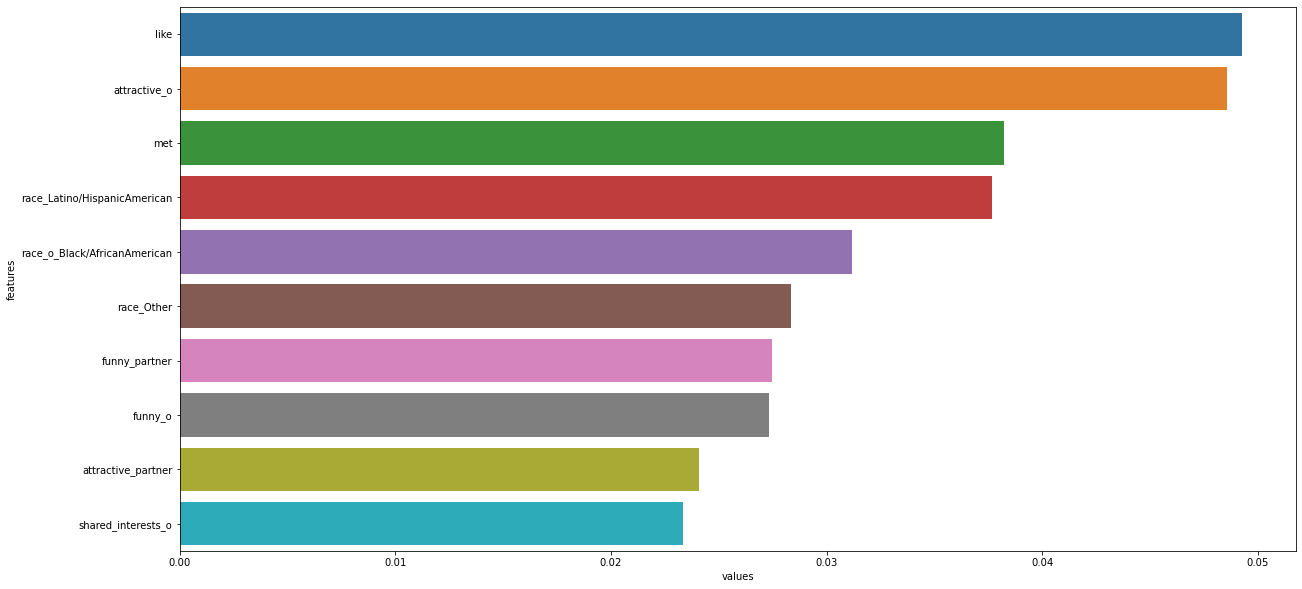

In [36]:
#변수별 중요도 시각화

plt.figure(figsize = (20,10))
sns.barplot(x = 'values', y = 'features', data = feature_imp.sort_values('values', ascending = False).head(10))